# PyTorch and Albumentations for image classification

This example shows how to use Albumentations for image classification. We will use the [`Cats vs. Dogs` dataset](https://www.kaggle.com/shaunthesheep/microsoft-catsvsdogs-dataset). The task will be to detect whether an image contains a cat or a dog.

### Import the required libraries

In [1]:
from collections import defaultdict
import copy
import random
import os
import shutil
from urllib.request import urlretrieve

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import timm

cudnn.benchmark = True

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.17 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations


### Define functions to download an archived dataset and unpack it

In [2]:
class TqdmUpTo(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)


def download_url(url, filepath):
    directory = os.path.dirname(os.path.abspath(filepath))
    os.makedirs(directory, exist_ok=True)
    if os.path.exists(filepath):
        print("Filepath already exists. Skipping download.")
        return

    with TqdmUpTo(unit="B", unit_scale=True, unit_divisor=1024, miniters=1, desc=os.path.basename(filepath)) as t:
        urlretrieve(url, filename=filepath, reporthook=t.update_to, data=None)
        t.total = t.n


def extract_archive(filepath):
    extract_dir = os.path.dirname(os.path.abspath(filepath))
    shutil.unpack_archive(filepath, extract_dir)

### Split files from the dataset into the train and validation sets

Some files in the dataset are broken, so we will use only those image files that OpenCV could load correctly. We will use 20000 images for training, 4936 images for validation, and 10 images for testing.

In [3]:
import os
import glob
import random
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
# Define your dataset directory
dataset_directory = r"Y:\ML\datasets\barks\Barkley"

# Get all image file paths (assuming .jpg files)
image_paths = glob.glob(os.path.join(dataset_directory, "*/*.jpg"))

# Shuffle your dataset
random.seed(42)
random.shuffle(image_paths)

# Extract class names from the folder structure
# os.path.basename(os.path.dirname(image_path)) gets the folder name (class) of each image
class_names = sorted({os.path.basename(os.path.dirname(path)) for path in image_paths})

# Create a label map, mapping class names to integers
label_map = {class_name: idx for idx, class_name in enumerate(class_names)}

print(f"Label Map: {label_map}")

# Define split ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Ensure that the ratios sum to 1
assert train_ratio + val_ratio + test_ratio == 1, "Split ratios must sum to 1."

# Calculate split indices
total_images = len(image_paths)
train_index = int(total_images * train_ratio)
val_index = train_index + int(total_images * val_ratio)

# Split the image paths into train, validation, and test sets
train_images_filepaths = image_paths[:train_index]
val_images_filepaths = image_paths[train_index:val_index]
test_images_filepaths = image_paths[val_index:]

# Collect target labels based on the folder names
y_true = []

for path in image_paths:
    class_name = os.path.basename(os.path.dirname(path))
    class_index = class_names.index(class_name)
    y_true.append(class_index)
    
# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_true), y=y_true)

# Convert to a PyTorch tensor
class_weights_tensor = torch.FloatTensor(class_weights).to('cuda')  # Move to the device

# Print the number of images in each set (optional)
print(f"Training images: {len(train_images_filepaths)}")
print(f"Validation images: {len(val_images_filepaths)}")
print(f"Test images: {len(test_images_filepaths)}")
print(f"Class Weight Tensor: {class_weights_tensor}")

Label Map: {'IPL': 0, 'MNG': 1, 'NRR': 2, 'PLM': 3, 'TPT': 4}
Training images: 1216
Validation images: 152
Test images: 153
Class Weight Tensor: tensor([0.9974, 0.8545, 0.9877, 1.1022, 1.1022], device='cuda:0')


### Define a function to visualize images and their labels

Let's define a function that will take a list of images' file paths and their labels and visualize them in a grid. Correct labels are colored green, and incorrectly predicted labels are colored red.

In [4]:
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

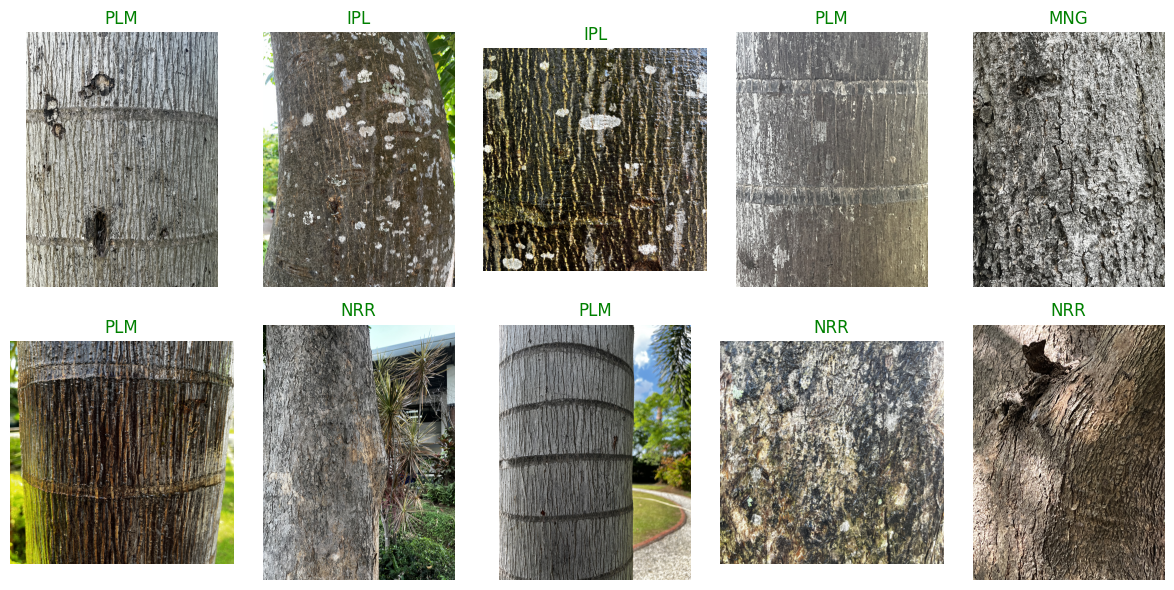

In [5]:
display_image_grid(test_images_filepaths[:10])

### Define a PyTorch dataset class

Next, we define a PyTorch dataset. If you are new to PyTorch datasets, please refer to this tutorial - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html.

Out task is binary classification - a model needs to predict whether an image contains a cat or a dog. Our labels will mark the probability that an image contains a cat. So the correct label for an image with a cat will be `1.0`, and the correct label for an image with a dog will be `0.0`.

`__init__` will receive an optional `transform` argument. It is a transformation function of the Albumentations augmentation pipeline. Then in `__getitem__`, the Dataset class will use that function to augment an image and return it along with the correct label.

In [6]:
class BarkDataset(Dataset):
    def __init__(self, images_filepaths, transform=None):
        self.images_filepaths = images_filepaths
        self.transform = transform
        
    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Extract label from the directory name (last part of the path)
        label = os.path.basename(os.path.dirname(image_filepath))
        
        # Map label to an integer (you can customize this mapping)
        label = label_map[label]

        if self.transform is not None:
            image = self.transform(image=image)["image"]

        return image, label

### Use Albumentations to define transformation functions for the train and validation datasets

We use Albumentations to define augmentation pipelines for training and validation datasets. In both pipelines, we first resize an input image, so its smallest size is 160px, then we take a 128px by 128px crop. For the training dataset, we also apply more augmentations to that crop. Next, we will normalize an image. We first divide all pixel values of an image by 255, so each pixel's value will lie in a range `[0.0, 1.0]`. Then we will subtract mean pixel values and divide values by the standard deviation. `mean` and `std` in augmentation pipelines are taken from the [`ImageNet` dataset](http://www.image-net.org/). Still, they transfer reasonably well to the `Cats vs. Dogs` dataset. After that, we will apply `ToTensorV2` that converts a NumPy array to a PyTorch tensor, which will serve as an input to a neural network.

Note that in the validation pipeline we will use `A.CenterCrop` instead of `A.RandomCrop` because we want out validation results to be deterministic (so that they will not depend upon a random location of a crop).

In [7]:
size = 224

In [8]:
train_transform = A.Compose(
    [
        A.Resize(height=size, width=size),
        A.RandomRotate90(),
        A.RandomHorizontalFlip(),
        A.RandomBrightnessContrast(p=0.3),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)       
train_dataset = BarkDataset(images_filepaths=train_images_filepaths, transform=train_transform)

In [9]:
val_transform = A.Compose(
    [
        A.Resize(width=size, height=size),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),

    ]
)
val_dataset = BarkDataset(images_filepaths=val_images_filepaths, transform=val_transform)
test_dataset = BarkDataset(images_filepaths=test_images_filepaths, transform=val_transform)

Also let's define a function that takes a dataset and visualizes different augmentations applied to the same image.

In [10]:
def visualize_augmentations(dataset, idx=0, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()    

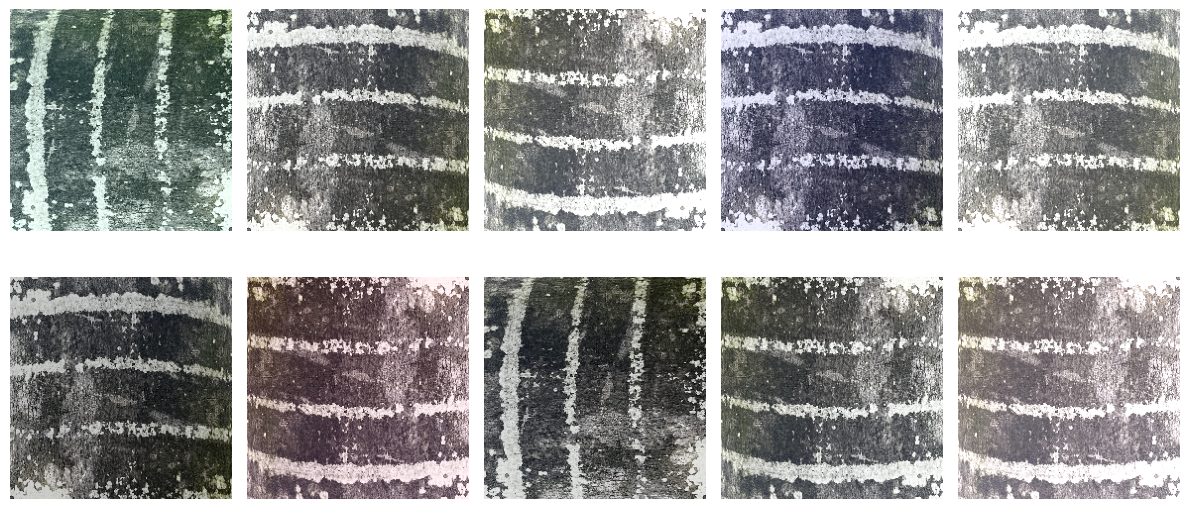

In [11]:
random.seed(42)
visualize_augmentations(train_dataset)

### Define helpers for training

We define a few helpers for our training pipeline. `calculate_accuracy` takes model predictions and true labels and will return accuracy for those predictions. `MetricMonitor` helps to track metrics such as accuracy or loss during training and validation

In [53]:
import json

def save_json_to_disk(data, directory, filename):
    """
    Creates a directory and saves the data as a JSON file.

    Args:
    - data (dict): The data to be saved in JSON format.
    - directory (str): The directory where the JSON file will be saved.
    - filename (str): The name of the JSON file (without extension).
    """
    # Create the directory if it doesn't exist
    os.makedirs(directory, exist_ok=True)

    # Full path for the JSON file
    json_file_path = os.path.join(directory, f"{filename}.json")

    # Write the JSON data to the specified file
    with open(json_file_path, 'w') as json_file:
        json.dump(data, json_file, indent=4)  # Optional: use indent for pretty printing

    print(f"Saved JSON data to {json_file_path}")

In [12]:
def calculate_accuracy(output, target):
    _, preds = torch.max(output, dim=1)
    return (preds == target).float().mean().item()

In [13]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

### Define training parameters 

Here we define a few training parameters such as model architecture, learning rate, batch size, epochs, etc

In [15]:
timm.list_models('resnet*')

['resnet10t',
 'resnet14t',
 'resnet18',
 'resnet18d',
 'resnet26',
 'resnet26d',
 'resnet26t',
 'resnet32ts',
 'resnet33ts',
 'resnet34',
 'resnet34d',
 'resnet50',
 'resnet50_clip',
 'resnet50_clip_gap',
 'resnet50_gn',
 'resnet50_mlp',
 'resnet50c',
 'resnet50d',
 'resnet50s',
 'resnet50t',
 'resnet50x4_clip',
 'resnet50x4_clip_gap',
 'resnet50x16_clip',
 'resnet50x16_clip_gap',
 'resnet50x64_clip',
 'resnet50x64_clip_gap',
 'resnet51q',
 'resnet61q',
 'resnet101',
 'resnet101_clip',
 'resnet101_clip_gap',
 'resnet101c',
 'resnet101d',
 'resnet101s',
 'resnet152',
 'resnet152c',
 'resnet152d',
 'resnet152s',
 'resnet200',
 'resnet200d',
 'resnetaa34d',
 'resnetaa50',
 'resnetaa50d',
 'resnetaa101d',
 'resnetblur18',
 'resnetblur50',
 'resnetblur50d',
 'resnetblur101d',
 'resnetrs50',
 'resnetrs101',
 'resnetrs152',
 'resnetrs200',
 'resnetrs270',
 'resnetrs350',
 'resnetrs420',
 'resnetv2_50',
 'resnetv2_50d',
 'resnetv2_50d_evos',
 'resnetv2_50d_frn',
 'resnetv2_50d_gn',
 'resnetv2

In [80]:
params = {
    "model": "resnet50",
    "device": "cuda",
    "lr": 2e-4,
    "batch_size": 32,
    "num_workers": 0,
    "epochs": 10,
    "weight_decay": 1e-6,
    "hub": "hf_hub:timm/resnet50.a1_in1k",
}
path = params['model']
if not os.path.exists(path):
    os.makedirs(path)
    print('Path created')

### Create all required objects and functions for training and validation

In [55]:
num_classes = len(label_map)  # Number of classes in your dataset
model = timm.create_model(params['hub'], pretrained=True, num_classes=num_classes).to(params['device'])

# Use CrossEntropyLoss for multi-class classification
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor).to(params["device"])
optimizer = torch.optim.AdamW(model.parameters(), lr=params["lr"], weight_decay=params['weight_decay'])

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/resnet50.a1_in1k)
INFO:timm.models._hub:[timm/resnet50.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Missing keys (fc.weight, fc.bias) discovered while loading pretrained weights. This is expected if model is being adapted.


In [64]:
train_loader = DataLoader(
    train_dataset, batch_size=params["batch_size"], shuffle=True, num_workers=params["num_workers"], pin_memory=True,
)
val_loader = DataLoader(
    val_dataset, batch_size=params["batch_size"], shuffle=False, num_workers=params["num_workers"], pin_memory=True,
)
# Initialize dictionaries for storing metrics
training_metrics = defaultdict(list)
validation_metrics = defaultdict(list)
combined_metrics = defaultdict(lambda: {"training": [], "validation": []})

In [68]:
best_loss = float('inf')  # Initialize best loss
def save_best_checkpoint(model, optimizer, epoch, training_metrics, validation_metrics, current_loss, filename=path+'\best_checkpoint.pth'):
    global best_loss
    if current_loss < best_loss:
        best_loss = current_loss  # Update best loss
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'training_metrics': training_metrics,
            'validation_metrics': validation_metrics,
        }
        torch.save(checkpoint, filename)
        print(f'Best checkpoint saved to {filename} with loss: {current_loss:.4f}')

def load_best_checkpoint(model, optimizer, filename=path+'\best_checkpoint.pth'):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    training_metrics = checkpoint['training_metrics']
    validation_metrics = checkpoint['validation_metrics']
    
    print(f'Best checkpoint loaded from {filename}, starting from epoch {epoch}')
    return epoch, training_metrics, validation_metrics

In [69]:
def train(train_loader, model, criterion, optimizer, epoch, params):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    for i, (images, target) in enumerate(stream, start=1):
        images = images.to(params["device"], non_blocking=True)
        target = target.to(params["device"], non_blocking=True).long()  # Target is a class index, use long()

        output = model(images)
        loss = criterion(output, target)

        accuracy = calculate_accuracy(output, target)  # Multi-class accuracy function
        metric_monitor.update("Loss", loss.item())
        metric_monitor.update("Accuracy", accuracy)
        
        # Store epoch metrics
        training_metrics[epoch].append({'loss': loss.item(), 'accuracy': accuracy})
        # Update combined metrics
        combined_metrics[epoch]["training"].append({'loss': loss.item(), 'accuracy': accuracy})
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )

    # Save validation metrics to JSON after the epoch
    save_json_to_disk(training_metrics, path, 'training_metrics')

In [70]:
def validate(val_loader, model, criterion, epoch, params):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            images = images.to(params["device"], non_blocking=True)
            target = target.to(params["device"], non_blocking=True).long()  # Target is a class index, use long()

            output = model(images)
            loss = criterion(output, target)

            accuracy = calculate_accuracy(output, target)  # Multi-class accuracy function
            metric_monitor.update("Loss", loss.item())
            metric_monitor.update("Accuracy", accuracy)

            # Store epoch metrics
            validation_metrics[epoch].append({'loss': loss.item(), 'accuracy': accuracy})

            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )
            
    # Save the best checkpoint based on the lowest loss after completing all validations
    save_best_checkpoint(model, optimizer, epoch, training_metrics, validation_metrics, best_loss)

    # Save validation metrics to JSON after the epoch
    save_json_to_disk(validation_metrics, path, 'validation_metrics')

### Train a model

In [71]:
for epoch in range(1, params["epochs"] + 1):
    train(train_loader, model, criterion, optimizer, epoch, params)
    validate(val_loader, model, criterion, epoch, params)

Epoch: 1. Train.      Loss: 0.579 | Accuracy: 0.822: 100%|█████████████████████████████| 76/76 [07:12<00:00,  5.69s/it]


Saved JSON data to resnet50\training_metrics.json


Epoch: 1. Validation. Loss: 0.214 | Accuracy: 0.912: 100%|█████████████████████████████| 10/10 [00:51<00:00,  5.16s/it]


Saved JSON data to resnet50\validation_metrics.json


Epoch: 2. Train.      Loss: 0.336 | Accuracy: 0.886: 100%|█████████████████████████████| 76/76 [06:44<00:00,  5.32s/it]


Saved JSON data to resnet50\training_metrics.json


Epoch: 2. Validation. Loss: 0.099 | Accuracy: 0.988: 100%|█████████████████████████████| 10/10 [00:51<00:00,  5.12s/it]


Saved JSON data to resnet50\validation_metrics.json


Epoch: 3. Train.      Loss: 0.282 | Accuracy: 0.909: 100%|█████████████████████████████| 76/76 [06:50<00:00,  5.40s/it]


Saved JSON data to resnet50\training_metrics.json


Epoch: 3. Validation. Loss: 0.079 | Accuracy: 0.975: 100%|█████████████████████████████| 10/10 [00:50<00:00,  5.05s/it]


Saved JSON data to resnet50\validation_metrics.json


Epoch: 4. Train.      Loss: 0.206 | Accuracy: 0.944: 100%|█████████████████████████████| 76/76 [06:55<00:00,  5.47s/it]


Saved JSON data to resnet50\training_metrics.json


Epoch: 4. Validation. Loss: 0.052 | Accuracy: 0.988: 100%|█████████████████████████████| 10/10 [00:54<00:00,  5.40s/it]


Saved JSON data to resnet50\validation_metrics.json


Epoch: 5. Train.      Loss: 0.183 | Accuracy: 0.936: 100%|█████████████████████████████| 76/76 [07:13<00:00,  5.71s/it]


Saved JSON data to resnet50\training_metrics.json


Epoch: 5. Validation. Loss: 0.034 | Accuracy: 1.000: 100%|█████████████████████████████| 10/10 [00:55<00:00,  5.58s/it]


Saved JSON data to resnet50\validation_metrics.json


Epoch: 6. Train.      Loss: 0.132 | Accuracy: 0.956: 100%|█████████████████████████████| 76/76 [06:53<00:00,  5.44s/it]


Saved JSON data to resnet50\training_metrics.json


Epoch: 6. Validation. Loss: 0.053 | Accuracy: 0.994: 100%|█████████████████████████████| 10/10 [00:49<00:00,  4.98s/it]


Saved JSON data to resnet50\validation_metrics.json


Epoch: 7. Train.      Loss: 0.142 | Accuracy: 0.954: 100%|█████████████████████████████| 76/76 [06:36<00:00,  5.21s/it]


Saved JSON data to resnet50\training_metrics.json


Epoch: 7. Validation. Loss: 0.035 | Accuracy: 0.994: 100%|█████████████████████████████| 10/10 [00:50<00:00,  5.09s/it]


Saved JSON data to resnet50\validation_metrics.json


Epoch: 8. Train.      Loss: 0.108 | Accuracy: 0.969: 100%|█████████████████████████████| 76/76 [06:46<00:00,  5.34s/it]


Saved JSON data to resnet50\training_metrics.json


Epoch: 8. Validation. Loss: 0.021 | Accuracy: 0.994: 100%|█████████████████████████████| 10/10 [00:49<00:00,  4.99s/it]


Saved JSON data to resnet50\validation_metrics.json


Epoch: 9. Train.      Loss: 0.120 | Accuracy: 0.964: 100%|█████████████████████████████| 76/76 [06:43<00:00,  5.31s/it]


Saved JSON data to resnet50\training_metrics.json


Epoch: 9. Validation. Loss: 0.024 | Accuracy: 0.994: 100%|█████████████████████████████| 10/10 [00:53<00:00,  5.33s/it]


Saved JSON data to resnet50\validation_metrics.json


Epoch: 10. Train.      Loss: 0.130 | Accuracy: 0.964: 100%|████████████████████████████| 76/76 [06:58<00:00,  5.51s/it]


Saved JSON data to resnet50\training_metrics.json


Epoch: 10. Validation. Loss: 0.018 | Accuracy: 0.994: 100%|████████████████████████████| 10/10 [00:50<00:00,  5.03s/it]

Saved JSON data to resnet50\validation_metrics.json


In [86]:
# Call the function to save the JSON
save_json_to_disk({'classes': class_names}, path, 'classes')
save_json_to_disk(combined_metrics, path, 'training_state')

Saved JSON data to resnet50\classes.json
Saved JSON data to resnet50\training_state.json


## Plot

In [83]:
# Function to load training state from a JSON file
def load_json(filepath):
    """
    Loads the training metrics from a JSON file.

    Args:
    - filepath (str): The path to the JSON file to be loaded.

    Returns:
    - data (dict or None): Returns the loaded data if successful, None otherwise.
    """
    if not os.path.exists(filepath):
        print(f"File not found: {filepath}")
        return None

    try:
        with open(filepath, 'r') as f:
            data = json.load(f)  # Load the JSON data
        print(f"Loaded successfully from {filepath}")
        return data
    except json.JSONDecodeError:
        print(f"File {filepath} is empty or contains invalid JSON.")
        return None
    except Exception as e:
        print(f"Error loading: {e}")
        return None

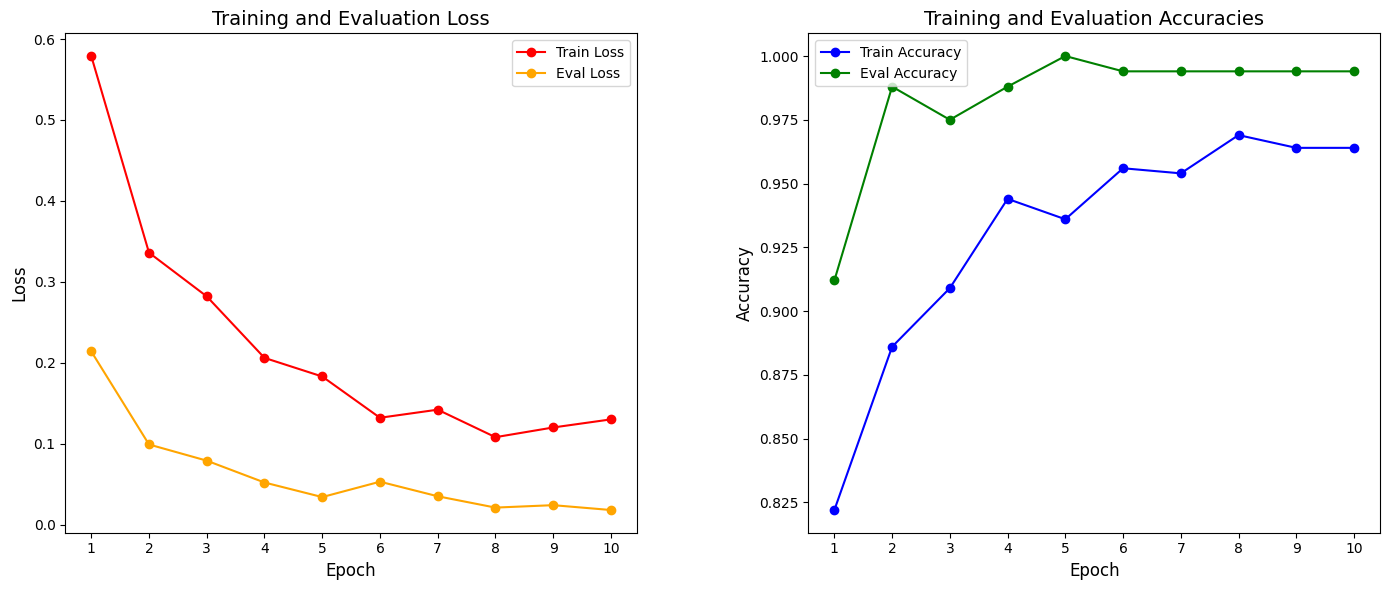

In [77]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Assuming 'training_metrics' is your dictionary containing the training data.
training_metrics = {
    1: {"train": {"loss": 0.579, "accuracy": 0.822}, "validation": {"loss": 0.214, "accuracy": 0.912}},
    2: {"train": {"loss": 0.336, "accuracy": 0.886}, "validation": {"loss": 0.099, "accuracy": 0.988}},
    3: {"train": {"loss": 0.282, "accuracy": 0.909}, "validation": {"loss": 0.079, "accuracy": 0.975}},
    4: {"train": {"loss": 0.206, "accuracy": 0.944}, "validation": {"loss": 0.052, "accuracy": 0.988}},
    5: {"train": {"loss": 0.183, "accuracy": 0.936}, "validation": {"loss": 0.034, "accuracy": 1.000}},
    6: {"train": {"loss": 0.132, "accuracy": 0.956}, "validation": {"loss": 0.053, "accuracy": 0.994}},
    7: {"train": {"loss": 0.142, "accuracy": 0.954}, "validation": {"loss": 0.035, "accuracy": 0.994}},
    8: {"train": {"loss": 0.108, "accuracy": 0.969}, "validation": {"loss": 0.021, "accuracy": 0.994}},
    9: {"train": {"loss": 0.120, "accuracy": 0.964}, "validation": {"loss": 0.024, "accuracy": 0.994}},
    10: {"train": {"loss": 0.130, "accuracy": 0.964}, "validation": {"loss": 0.018, "accuracy": 0.994}}
}

# Extracting data for plotting
epochs = list(training_metrics.keys())
train_losses = [metrics['train']['loss'] for metrics in training_metrics.values()]
val_losses = [metrics['validation']['loss'] for metrics in training_metrics.values()]
train_accuracies = [metrics['train']['accuracy'] for metrics in training_metrics.values()]
val_accuracies = [metrics['validation']['accuracy'] for metrics in training_metrics.values()]

# Create a figure with two subplots arranged side by side
plt.figure(figsize=(14, 6))  

# Plot training and evaluation losses
plt.subplot(1, 2, 1)  
plt.plot(epochs, train_losses, label='Train Loss', color='red', marker='o')
plt.plot(epochs, val_losses, label='Eval Loss', color='orange', marker='o')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training and Evaluation Loss', fontsize=14)
plt.legend()
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Plot training and evaluation accuracies
plt.subplot(1, 2, 2)  
plt.plot(epochs, train_accuracies, label='Train Accuracy', color='blue', marker='o')
plt.plot(epochs, val_accuracies, label='Eval Accuracy', color='green', marker='o')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Training and Evaluation Accuracies', fontsize=14)
plt.legend()
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Adjust layout and spacing
plt.tight_layout()
plt.subplots_adjust(wspace=0.3)

# Save the figure with high resolution
plt.savefig(f"{params['model']}/train_and_eval.jpg", dpi=300)

# Show the plot
plt.show()

## Export to ONNX

### Save

In [89]:
import torch.onnx 


# set the model to inference mode 
model.eval() 

# Let's create a dummy input tensor  
dummy_input = torch.randn(1, 3, size, size).to(params["device"])  # Adjust shape as necessary

# Specify the path where you want to save the ONNX model
onnx_model_path = path+"/model.onnx"

# Export the model
torch.onnx.export(
    model,
    dummy_input,
    onnx_model_path,
    export_params=True,  # Store the trained parameter weights inside the model file
    opset_version=11,    # ONNX version to export the model to
    do_constant_folding=True,  # Whether to optimize constant expressions
    input_names=['input'],      # Names of the input nodes
    output_names=['output'],     # Names of the output nodes
    dynamic_axes={
        'input': {0: 'batch_size'},  # Variable batch size
        'output': {0: 'batch_size'}, # Variable batch size
    }
)

print(f"Model exported to {onnx_model_path}")

Model exported to resnet50/model.onnx


### Load

In [90]:
import cv2
import numpy as np
import onnx
import onnxruntime
import albumentations as A


# Function to prepare the image and perform inference
def pipeline_onnx(image_filepath, onnx_model_path):
    # Load the image
    image = cv2.imread(image_filepath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Define your transformations (same as used during training)
    transform = A.Compose(
        [
            A.Resize(width=size, height=size),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
        ]
    )
    
     # Apply transformations
    image = transform(image=image)["image"]
    
    # Add batch dimension and convert to NumPy array
    image = image.unsqueeze(0).cpu().numpy()  # shape: [1, C, H, W]

    # Load the ONNX model
    ort_session = onnxruntime.InferenceSession(onnx_model_path)

    # Prepare input data for ONNX Runtime
    ort_inputs = {ort_session.get_inputs()[0].name: image}

    # Run inference
    ort_outputs = ort_session.run(None, ort_inputs)

    # Extract predictions and apply softmax to get probabilities
    scores = ort_outputs[0]
    probabilities = torch.softmax(torch.tensor(scores), dim=1).numpy()  # shape: [1, num_classes]

    # Get predicted indices and corresponding confidence scores
    predictions = [(class_names[i], probabilities[0][i]) for i in range(len(class_names))]

    # Sort predictions by confidence score in descending order
    sorted_predictions = sorted(predictions, key=lambda x: x[1], reverse=True)

    return sorted_predictions

# Example usage
image_filepath = test_images_filepaths[0]  # Use the first image from your test dataset
class_names = load_json(f'{params['model']}/classes.json')['classes']
predictions = pipeline_onnx(image_filepath, onnx_model_path)

# Print sorted predictions with confidence scores
for label, score in predictions:
    print(f'Predicted label: {label}, Confidence score: {score:.4f}')

Loaded successfully from resnet50/classes.json
Predicted label: PLM, Confidence score: 0.9426
Predicted label: IPL, Confidence score: 0.0363
Predicted label: MNG, Confidence score: 0.0146
Predicted label: NRR, Confidence score: 0.0037
Predicted label: TPT, Confidence score: 0.0028


In [91]:
test_images_filepaths[0]

'Y:\\ML\\datasets\\barks\\Barkley\\PLM\\IMG_0275.jpg'

## Predict labels for images and visualize those predictions

#### Inferene Helpers

In [92]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd

# Function to prepare the image and perform inference with ONNX model
def pipeline_onnx(image_filepath, ort_session):
    # Load the image
    image = cv2.imread(image_filepath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Define your transformations (same as used during training)
    transform = A.Compose(
        [
            A.Resize(width=224, height=224),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
        ]
    )
    
    # Apply transformations
    image = transform(image=image)["image"]
    
    # Add batch dimension and convert to NumPy array
    image = image.unsqueeze(0).cpu().numpy()  # shape: [1, C, H, W]

    # Prepare input data for ONNX Runtime
    ort_inputs = {ort_session.get_inputs()[0].name: image}

    # Run inference
    ort_outputs = ort_session.run(None, ort_inputs)

    # Extract predictions and apply softmax to get probabilities
    scores = ort_outputs[0]
    probabilities = torch.softmax(torch.tensor(scores), dim=1).numpy()  # shape: [1, num_classes]

    # Get predicted class index
    predicted_idx = np.argmax(probabilities)

    return predicted_idx

In [94]:
# Function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    
    # Save the plot in high quality
    plt.savefig(f'{params['model']}/plot_confusion_matrix.png', dpi=300)
    plt.show()

# Function to plot classification report metrics (Precision, Recall, F1-score)
def plot_classification_report(report_dict, class_names):
    # Convert the report to DataFrame
    metrics_df = pd.DataFrame(report_dict).T

    # Filter out accuracy and add macro avg and weighted avg
    metrics_to_plot = metrics_df[['precision', 'recall', 'f1-score']].drop(["accuracy"], errors='ignore')

    # Plot Precision, Recall, and F1-score for all classes including macro and weighted avg
    metrics_to_plot.plot(kind='bar', figsize=(12, 6), colormap='viridis')
    
    # Set titles and labels
    plt.title('Classification Metrics for Each Class (Including Macro and Weighted Averages)')
    plt.xlabel('Classes')
    plt.xticks(np.arange(len(metrics_to_plot.index)), metrics_to_plot.index, rotation=45)
    plt.ylabel('Score')
    plt.legend(loc="lower right")
    
    # Save the plot in high quality
    plt.savefig(f'{params['model']}/classification_report_plot.png', dpi=300)
    plt.show()

# Updated evaluation function to include classification metrics plotting
def evaluate_onnx_model(test_images_filepaths, onnx_model_path):
    ort_session = onnxruntime.InferenceSession(onnx_model_path)
    # Collect true labels specifically for the test set
    y_true_test = []
    for path in test_images_filepaths:
        class_name = os.path.basename(os.path.dirname(path))
        class_index = class_names.index(class_name)
        y_true_test.append(class_index)

    y_pred_test = []

    for image_filepath in test_images_filepaths:
        predicted_idx = pipeline_onnx(image_filepath, ort_session)
        y_pred_test.append(predicted_idx)

    # Generate a classification report using true and predicted labels
    report = classification_report(y_true_test, y_pred_test, target_names=class_names, output_dict=True)
    
    # Print the classification report
    print(classification_report(y_true_test, y_pred_test, target_names=class_names))

    # Plot confusion matrix
    plot_confusion_matrix(y_true_test, y_pred_test, class_names)

    # Plot classification metrics (Precision, Recall, F1-score)
    plot_classification_report(report, class_names)


### Inference

              precision    recall  f1-score   support

         IPL       0.97      1.00      0.98        30
         MNG       1.00      0.91      0.96        35
         NRR       0.90      0.96      0.93        28
         PLM       1.00      1.00      1.00        24
         TPT       1.00      1.00      1.00        36

    accuracy                           0.97       153
   macro avg       0.97      0.98      0.97       153
weighted avg       0.98      0.97      0.97       153



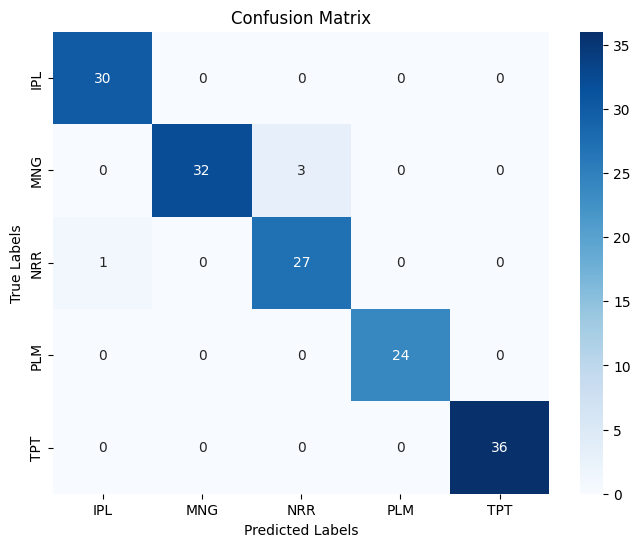

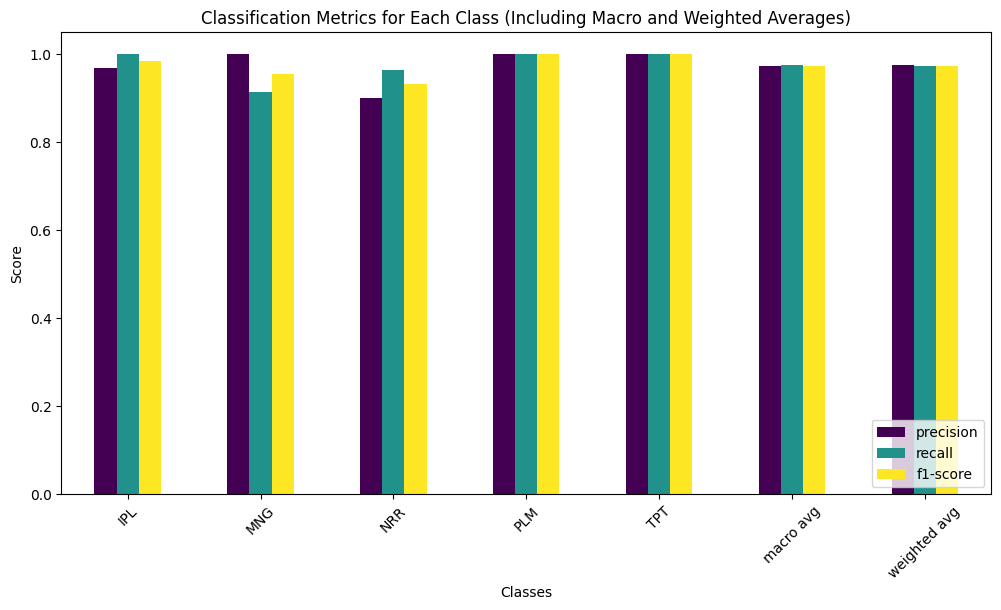

In [96]:
# Get the classification report, plot confusion matrix, and plot metrics
evaluate_onnx_model(test_images_filepaths, onnx_model_path)